# Алгоритмическая торговля на примере объёмной дельты (Volume Delta)

**Автор:** Мячин Платон 

---

## Описание проекта

В этом ноутбуке представлено исследование и бэктестинг торговой стратегии на основе **Volume Delta**. Все данные были собраны самостоятельно при помощи собственного **парсера**, реализованного на WebSocket API Bybit. Метрики и индикаторы (Value Area, VPIN, OFI, RF, Kyle’s Lambda, Volume Delta и др.) также написаны с нуля в модуле `functions.py`.

На текущем этапе:
- Фокусируемся исключительно на работе с **Volume Delta** — поиске экстремальных изменений, нормализации относительно средних значений и генерации сигналов входа/выхода.
- Используем формат хранения **parquet** вместо CSV для трёхкратного ускорения чтения и снижения потребления дискового пространства.
- Сигналы тестируются через «галочки» на барах (15 min), а вход/выход по рыночным тикам.

## Возникшие сложности

1. **Перевод CSV → Parquet**  
   Переход к Parquet дал существенное ускорение, но потребовал выстраивания буферизированной записи, синхронизации по датам и фиксации схемы Arrow.

2. **Сдвиг и выравнивание временных рядов**  
   Непросто было согласовать временнýю сетку 15 min—binned индикаторов с тиковыми данными цены и стакана. Приходилось аккуратно выбирать nearest/ffill и следить за NaN.

3. **Динамический TP/SL**  
   Поиск уровней стоп-лосса и тейк-профита на основе ATR/волатильности затронул логику ближайших тиков, что вылилось в серию итераций и баг‑фиксов.

---

> **Дальнейшие планы**:  
> - Расширить эксперимент на остальные индикаторы из `functions.py` (RF, VPIN, OFI, Kyle’s Lambda).  
> - Автоматизировать перебор параметров (Grid Search / Bayesian Optimization).  
> - Интегрировать визуализацию spread/slippage и глубины книги в реальном времени.  

---  


In [ ]:
import sys
from pathlib import Path          

sys.path.append(str(Path("src").resolve()))
import functions

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import functions #свой файл с функциями чтения данных и расчета
import numpy as np
import math, pyarrow.parquet as pq, os, glob
import pandas as pd

In [7]:
# import pandas as pd
# import numpy as np

# # ==== Фейковые функции вместо твоих ====
# def fake_vpin(df, period, bucket_size, window_length):
#     return (
#         df.set_index('recv_time')['price']
#           .resample(period, origin='start_day', label='left', closed='left')
#           .mean()
#           .rename('vpin')
#     )

# def fake_ofi(df, period):
#     return (
#         df.set_index('recv_time')['bid']
#           .resample(period, origin='start_day', label='left', closed='left')
#           .sum()
#           .rename('ofi')
#     )

# def fake_price_bar(df, period):
#     return (
#         df.set_index('recv_time')['price']
#           .resample(period, origin='start_day', label='left', closed='left')
#           .last()
#           .ffill()
#           .rename('price')
#     )

# def fake_va(df, period, step):
#     return (
#         df.set_index('recv_time')['price']
#           .resample(period, origin='start_day', label='left', closed='left')
#           .mean()
#           .rename('POC_price')
#           .to_frame()
#     )

# def fake_delta(df, period):
#     return (
#         df.set_index('recv_time')['price']
#           .resample(period, origin='start_day', label='left', closed='left')
#           .sum()
#           .rename('volume_delta')
#     )

# # ==== Генерация тестовых данных ====
# date_rng = pd.date_range("2025-01-01", periods=2000, freq="T")  # каждую минуту
# tick_df = pd.DataFrame({
#     'recv_time': date_rng,
#     'price': np.random.rand(len(date_rng)) * 100
# })
# ob_df = pd.DataFrame({
#     'recv_time': date_rng,
#     'bid': np.random.randint(1, 10, len(date_rng))
# })

# ticks_by_day = [tick_df]
# ob_by_day = [ob_df]

# PERIOD_BIG = '1h'
# PERIOD_SMALL = '15min'
# STEP = 0.5

# # ==== Логика ====
# indicators_by_day = []

# for tick_df, ob_df in zip(ticks_by_day, ob_by_day):
#     tick_df['recv_time'] = pd.to_datetime(tick_df['recv_time'])
#     ob_df['recv_time'] = pd.to_datetime(ob_df['recv_time'])

#     vpin = fake_vpin(tick_df.copy(), PERIOD_SMALL, 0, 0)
#     ofi = fake_ofi(ob_df, PERIOD_SMALL)
#     price_bar = fake_price_bar(tick_df, PERIOD_SMALL)

#     base_df = pd.concat([vpin, ofi, price_bar], axis=1)

#     va_df = fake_va(tick_df.copy(), PERIOD_BIG, STEP)
#     delta = fake_delta(tick_df.copy(), PERIOD_BIG)

#     hourly_df = pd.concat([va_df, delta], axis=1)

#     merged_df = pd.merge_asof(
#         base_df.sort_index(),
#         hourly_df.sort_index(),
#         left_index=True,
#         right_index=True,
#         direction='backward'
#     )

#     indicators_by_day.append(merged_df)

# indicators_df = pd.concat(indicators_by_day).sort_index()
# indicators_df.index.name = 'recv_time'

# # ffill для часовых метрик
# to_fill = ['POC_price', 'volume_delta']
# indicators_df[to_fill] = indicators_df[to_fill].ffill()

# # Убираем дубликаты
# indicators_df = indicators_df[~indicators_df.index.duplicated(keep='last')]

# print("Оригинальное количество строк в base_df:", len(base_df))
# print("Количество строк после merge_asof:", len(indicators_df))
# print(indicators_df.head(20))

In [8]:
ticks_by_day, ob_by_day = functions.read_files_by_day('2025-07-12', '2025-08-11')

# # 2) Если вам нужен единый DataFrame «замороженных» данных:
# df = pd.concat(ticks_by_day, ignore_index=True)
# odf = pd.concat(ob_by_day,    ignore_index=True)
# print(df)
# # 3) Приводим recv_time в datetime
# df['recv_time']  = pd.to_datetime(df['recv_time'])
# odf['recv_time'] = pd.to_datetime(odf['recv_time'])
# # odf = odf.set_index('recv_time')

In [9]:
# va_df      = functions.value_area(df.copy(), PERIOD_BIG, STEP)
# delta      = functions.volume_delta(df.copy(), PERIOD_BIG).rename('volume_delta')
# vpin       = functions.VPIN(df.copy(), PERIOD_SMALL, functions.BUCKET_SIZE, functions.WINDOW_LENGTH)
# ofi        = functions.process_order_flow_imbalance(odf, PERIOD_SMALL)
# rf         = functions.RF(va_df)
# kyle_lambda= functions.vectorized_kyle_lambda(df.copy(), PERIOD_BIG)
# cum_delta  = functions.cummulutive_delta(df.copy(), PERIOD_BIG)

In [10]:
ticks_total = 0
for df in ticks_by_day:
    ticks_total+=len(df)

ob_total = 0
for df in ob_by_day:
    ob_total+=len(df)

print('ticks len:', ticks_total, '\nob len:', ob_total)
print('ticks list len:', len(ticks_by_day), '\nob list len:', len(ob_by_day))


ticks len: 17451106 
ob len: 298333096
ticks list len: 23 
ob list len: 23


In [11]:
def process_order_flow_imbalance_by_day(odf: pd.DataFrame, period: str) -> pd.Series:
    odf = odf.copy()
    odf['recv_time'] = pd.to_datetime(odf['recv_time'])
    period_ns = pd.to_timedelta(period).value

    series_list = []
    for day, g in odf.groupby(odf['recv_time'].dt.normalize()):
        # anchor = midnight текущего дня
        t0 = day.value  # int64 nanos since epoch
        # last nanosecond of the day
        t_last = (day + pd.Timedelta(days=1) - pd.Timedelta(nanoseconds=1)).value
        max_bins = int((t_last - t0) // period_ns) + 1

        # подготовка входных массивов — только для этой группы
        ts_ns   = g['recv_time'].astype('int64').to_numpy()
        typ     = (g['type'] == 'delta').to_numpy(np.int8)
        side    = (g['side'] == 'Sell').to_numpy(np.int8)
        price   = g['price'].to_numpy(np.float64)
        size    = g['size'].to_numpy(np.float64)

        ofi_vals = functions._ofi_numba(ts_ns, typ, side, price, size, t0, period_ns, max_bins)

        bin_times = pd.to_datetime(t0 + np.arange(max_bins, dtype=np.int64) * period_ns)
        s = pd.Series(ofi_vals, index=bin_times, name='OFI')
        series_list.append(s)

    # Соединяем дни в единый Series (index будет упорядочен по времени)
    return pd.concat(series_list).sort_index()

In [266]:
# if 'recv_time' not in df.columns:
#     df = df.reset_index()

PERIOD_BIG = '1h'
PERIOD_SMALL = '15min'
PERIOD_TINY = '5min'
STEP = 0.5

# del indicators_df  # полное удаление объекта

indicators_by_day = []
total_len_vpin= 0
total_len_ofi = 0
total_len_ind = 0

for tick_df, ob_df in zip(ticks_by_day, ob_by_day):
    tick_df = tick_df.copy()
    ob_df = ob_df.copy()

    tick_df['recv_time'] = pd.to_datetime(tick_df['recv_time'])
    ob_df['recv_time']  = pd.to_datetime(ob_df['recv_time'])

    # tick_df = tick_df.sort_values('recv_time')
    # ob_df  = ob_df.sort_values('recv_time')

    # 1) price_bar — явная 15-мин сетка, используем её как базу
    price_bar = (
        tick_df.set_index('recv_time')['price']
            .resample(PERIOD_TINY, origin='start_day', label='left', closed='left')
            .last()
            .ffill()
            .rename('price')
    )
    # price_index = price_bar.index

    # 2) 15-минутные метрики — пересадим их на price_index (anchor)
    # vpin = functions.VPIN(tick_df.copy(), PERIOD_SMALL, functions.BUCKET_SIZE, functions.WINDOW_LENGTH)

    # first_ts_before = ob_df['recv_time'].min()
    # last_ts_before = ob_df['recv_time'].max()
    # print("До OFI:", first_ts_before, "->", last_ts_before)

    # ofi = process_order_flow_imbalance_by_day(ob_df, PERIOD_SMALL)

    # print("После OFI:", ofi.index.min(), "->", ofi.index.max(), "len:", len(ofi))

    # Создаем временный DataFrame с временным индексом

    # print('ob_df time[0]', ob_df_resampled.index[0])
    # print('ob_df time[-1]', ob_df_resampled.index[-1])
    # reindex на price_index — чтобы гарантировать одинаковую сетку
    # vpin = vpin.reindex(price_index)
    # ofi  = ofi.reindex(price_index)
    # total_len_vpin += len(vpin)
    # total_len_ofi += len(ofi)

    # base_df = pd.concat([vpin, ofi], axis=1)  # price — опорная колонка
    # total_len_ind+=len(base_df)

    # 3) часовые (редкие) метрики
    va_df     = functions.value_area(tick_df.copy(), PERIOD_SMALL, STEP)
    delta     = functions.volume_delta(tick_df.copy(), PERIOD_SMALL).rename('volume_delta')
    # rf        = functions.RF(va_df)
    # k_lambda  = functions.vectorized_kyle_lambda(tick_df.copy(), PERIOD_BIG)
    # cum_delta = functions.cummulutive_delta(tick_df.copy(), PERIOD_BIG)

    # hourly_df = pd.concat([va_df, delta, rf, k_lambda, cum_delta], axis=1)

    # 4) подготовка к merge_asof: добавим колонку day, сбросим индекс (merge_asof проще на колонках)
    # base_df = base_df.reset_index().rename(columns={'index': 'recv_time'})
    # hourly_df = hourly_df.reset_index().rename(columns={'index': 'recv_time'})

    # base_df['day'] = base_df['recv_time'].dt.normalize()    # midnight timestamp — группируем по дню
    # hourly_df['day'] = hourly_df['recv_time'].dt.normalize()

    # base_df = base_df.sort_values(['day', 'recv_time'])
    # hourly_df = hourly_df.sort_values(['day', 'recv_time'])

    # # 5) merge_asof с by='day' — запретим "перетекание" значений между днями
    # #    Берём только часовые колонки из hourly_df (чтобы не перезаписывать price/vpin/ofi)
    # hourly_cols = [c for c in hourly_df.columns if c not in ('recv_time', 'day')]

    # merged = pd.merge_asof(
    #     base_df,
    #     hourly_df[['recv_time', 'day'] + hourly_cols],
    #     on='recv_time',
    #     by='day',
    #     direction='backward',
    #     tolerance=pd.Timedelta(PERIOD_BIG)  # опционально — можно ограничить поиск максимум 1 час
    # )

    # merged = merged.set_index('recv_time')
    # # на всякий случай — удалим дубликаты индекса (keep='last' как у тебя)
    # merged = merged[~merged.index.duplicated(keep='last')]

    # # debug print (удали в финале)
    # print("day", merged.index.min(), "->", merged.index.max(), "len:", len(merged))
    # # print("price_bar len:", len(price_bar))
    # print("vpin len:", len(vpin.dropna(how='all')))
    # print("hourly len:", len(hourly_df))
    # print("merged len:", len(merged))
    # # print("price_bar.index[:5]:", price_bar.index[:5])
    # print("hourly.index[:5]:", hourly_df['recv_time'].head())

    day_df = pd.concat([delta, va_df, price_bar], axis=1)
    indicators_by_day.append(day_df)

# итог
indicators_df = pd.DataFrame(pd.concat(indicators_by_day, axis=0)) #тут был .sort_index()
indicators_df = indicators_df[~indicators_df.index.duplicated(keep='last')]
# indicators_df.to_frame()
# print(indicators_df == pd.DataFrame)
# ffill для редких метрик как и раньше
# 3

#отладка

# print('total len ind' ,total_len_ind, '\n total len ofi:', total_len_ofi)
# print(type(indicators_df))
# print(len(indicators_df))
pd.set_option('display.max_rows', None)  # Все строки
pd.set_option('display.max_columns', None)  # Все столбцы
pd.set_option('display.width', None)  # Автоподбор ширины
pd.set_option('display.max_colwidth', None)  # Полный текст в ячейках
print(indicators_df)

                     volume_delta  POC_price  POC_volume       VAH       VAL  \
recv_time                                                                      
2025-07-15 14:00:00    456.558990   118400.0   74.620003  118484.0  118279.0   
2025-07-15 14:05:00           NaN        NaN         NaN       NaN       NaN   
2025-07-15 14:10:00           NaN        NaN         NaN       NaN       NaN   
2025-07-15 14:15:00   -382.615967   118052.0  105.722000  118400.0  117820.5   
2025-07-15 14:20:00           NaN        NaN         NaN       NaN       NaN   
2025-07-15 14:25:00           NaN        NaN         NaN       NaN       NaN   
2025-07-15 14:30:00   -708.461060   117200.0  156.490997  117655.0  117047.0   
2025-07-15 14:35:00           NaN        NaN         NaN       NaN       NaN   
2025-07-15 14:40:00           NaN        NaN         NaN       NaN       NaN   
2025-07-15 14:45:00  -1672.354004   116200.0  469.634003  116412.5  115912.0   
2025-07-15 14:50:00           NaN       

одна дельта_

In [267]:
# считаем функции
# va_df      = functions.value_area(df.copy(), PERIOD_BIG, STEP)
delta_      = functions.volume_delta(df.copy(), '1h').rename('volume_delta')
# vpin       = functions.VPIN(df.copy(), PERIOD_SMALL, functions.BUCKET_SIZE, functions.WINDOW_LENGTH)
# ofi        = process_order_flow_imbalance_by_day(odf, PERIOD_SMALL)
# rf         = functions.RF(va_df)
# kyle_lambda= functions.vectorized_kyle_lambda(df.copy(), PERIOD_BIG)
# cum_delta  = functions.cummulutive_delta(df.copy(), PERIOD_BIG)

# price_bar = (
#     df.set_index('recv_time')['price']
#       .resample(PERIOD_SMALL)
#       .last()
#       .ffill()
#       .rename('price'),
# )

#объединяю в один dataframe, неоторые рассчитываю с частотой 1час, некоторые с частотой 15мин
# indicators_df1 = pd.concat(
#     [vpin, ofi], axis=1
# )

# тут делаю ffill() для рассчитанных с меньшей частотой метрик
# to_fill = ['POC_price','POC_volume','VAH','VAL','RF','cum_delta','Kyle_Lambda']
# indicators_df1[to_fill] = indicators_df1[to_fill].ffill()

print(delta_)
print(len(delta_))


recv_time
2025-07-15 14:00:00   -2306.872070
2025-07-15 15:00:00     404.966797
2025-07-15 16:00:00    -442.808838
2025-07-15 17:00:00     160.136963
2025-07-15 18:00:00    -815.131104
2025-07-15 19:00:00     -60.317017
2025-07-15 20:00:00     175.328979
2025-07-15 21:00:00     964.432007
2025-07-15 22:00:00    -378.688965
2025-07-15 23:00:00      51.598999
2025-07-16 00:00:00     415.526978
2025-07-16 01:00:00      79.513000
2025-07-16 02:00:00    -754.758972
2025-07-16 03:00:00      48.354980
2025-07-16 04:00:00      85.203003
2025-07-16 05:00:00     208.364990
2025-07-16 06:00:00     261.851013
2025-07-16 07:00:00     -53.413025
2025-07-16 08:00:00     656.408936
2025-07-16 09:00:00     -23.716064
2025-07-16 10:00:00    -645.898010
2025-07-16 11:00:00    -236.529053
2025-07-16 12:00:00    -329.155029
2025-07-16 13:00:00     265.516113
2025-07-16 14:00:00    -180.532959
2025-07-16 15:00:00    -556.462891
2025-07-16 16:00:00     557.865845
2025-07-16 17:00:00     780.713013
2025-07-16

норм метод

In [268]:
# if 'recv_time' not in df.columns:
#     df = df.reset_index()

# PERIOD_BIG = '1h'
# PERIOD_SMALL = '15min'
# STEP = 0.5

# # считаем функции
# va_df      = functions.value_area(df.copy(), PERIOD_BIG, STEP)
# delta      = functions.volume_delta(df.copy(), PERIOD_BIG).rename('volume_delta')
# vpin       = functions.VPIN(df.copy(), PERIOD_SMALL, functions.BUCKET_SIZE, functions.WINDOW_LENGTH)
# ofi        = functions.process_order_flow_imbalance(odf, PERIOD_SMALL)
# rf         = functions.RF(va_df)
# kyle_lambda= functions.vectorized_kyle_lambda(df.copy(), PERIOD_BIG)
# cum_delta  = functions.cummulutive_delta(df.copy(), PERIOD_BIG)

# price_bar = (
#     df.set_index('recv_time')['price']
#       .resample(PERIOD_SMALL)
#       .last()
#       .ffill()
#       .rename('price'),
# )

# #объединяю в один dataframe, неоторые рассчитываю с частотой 1час, некоторые с частотой 15мин
# indicators_df = pd.concat(
#     [va_df, delta, vpin, rf, ofi, kyle_lambda, cum_delta], axis=1
# ).join(price_bar, how='left')

# # тут делаю ffill() для рассчитанных с меньшей частотой метрик
# to_fill = ['POC_price','POC_volume','VAH','VAL','RF','cum_delta','Kyle_Lambda']
# indicators_df[to_fill] = indicators_df[to_fill].ffill()

тест

In [269]:
# # delta из первого метода
# delta_first = indicators_df.copy()
# delta_first.index.name = 'recv_time'
# delta_first = delta_first.sort_index()

# # delta из второго метода
# delta_second = delta.copy()
# delta_second.index.name = 'recv_time'
# delta_second = delta_second.sort_index()


# # Вариант 2: Сравнение как DataFrame
# delta_second_df = delta_second.to_frame('volume_delta')
# print("Тип delta_first:", type(delta_first))
# print("Тип delta_second:", type(delta_second))
# diff_df = delta_first.compare(delta_second_df)
# print("\nСравнение как DataFrame:\n", diff_df)

заполнения времен открытия по индикаторам (на данный момент единственный включенный в исследование индикатор - volume delta, смотрите ниже)

VAH/VAL/POC

In [270]:
def value_area_conditions(indicators_df):
    P = indicators_df['price']
    H = indicators_df['VAH']
    L = indicators_df['VAL']

    P_prev = P.shift(1)
    H_prev = H.shift(1)
    L_prev = L.shift(1)

    P_prev_prev = P.shift(2)
    H_prev_prev = H.shift(2)
    L_prev_prev  = L.shift(2)

    # P_next = P.shift(-1)
    # H_next = H.shift(-1)
    # L_next = L.shift(-1)

    indicators_df['VAH_sell'] =(P_prev >= H_prev) & (P < H) 
    # & (P_prev >= H_prev)
    indicators_df['VAL_buy']  =(P_prev <= L_prev) & (P > L) 
    # & (P_prev <= L_prev)

    df_prev = indicators_df.shift(1)
    df_next = indicators_df.shift(-3)

    ratios_list = []
    ratios_index = []
    signal_type = []

    # VAH_sell
    for idx, row in indicators_df[indicators_df['VAH_sell']].iterrows():
        if idx == indicators_df.index[-3]:
            continue
        if pd.isna(df_next.loc[idx]['price']):
            continue
        next_idx = indicators_df.index[indicators_df.index.get_loc(idx) + 3]
        if idx.day != next_idx.day:
            continue

        ratio = df_next.loc[idx]['price'] / row['price']
        ratios_list.append(ratio)
        ratios_index.append(idx)
        signal_type.append('VAH_sell')

    # VAL_buy
    for idx, row in indicators_df[indicators_df['VAL_buy']].iterrows():
        if idx == indicators_df.index[-3]:
            continue
        if pd.isna(df_next.loc[idx]['price']):
            continue
        next_idx = indicators_df.index[indicators_df.index.get_loc(idx) + 3]
        if idx.day != next_idx.day:
            continue

        ratio = df_next.loc[idx]['price'] / row['price']
        ratios_list.append(ratio)
        ratios_index.append(idx)
        signal_type.append('VAL_buy')

    ratios_df = pd.DataFrame({
        'price_ratio': ratios_list,
        'signal_type': signal_type
    }, index=ratios_index)

    return indicators_df, ratios_df
# разделить на хорошие отношения и
indicators_df_, ratios_VA = value_area_conditions(indicators_df)

 отрисовка зависимости изменения цены от VAH, VAL ...

VAL_buy: рост в 100.0% случаев, среднее 0.1204%
VAH_sell: падение в 50.0% случаев, среднее -0.0100%


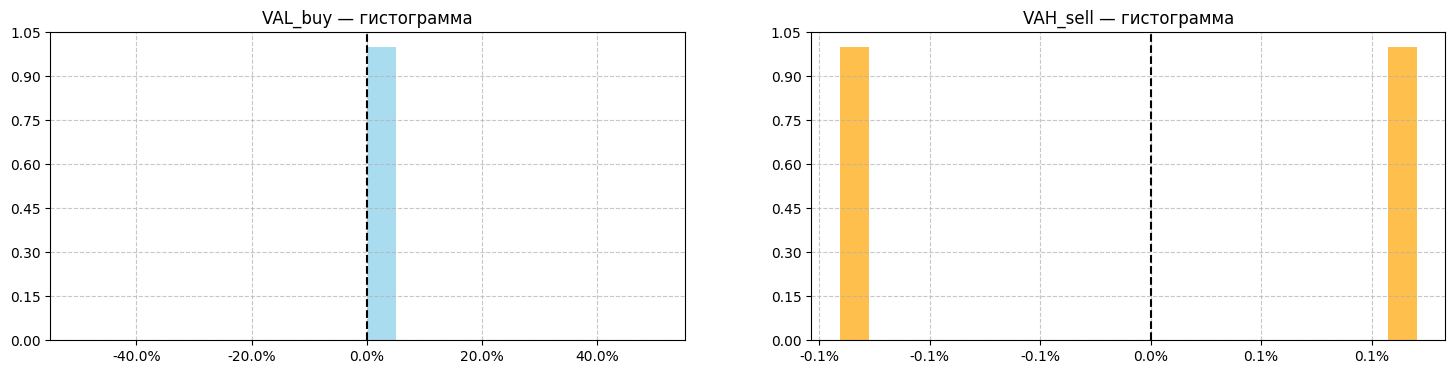

In [271]:
from matplotlib.ticker import MaxNLocator, MultipleLocator, FuncFormatter
indicators_df_, ratios_VA = value_area_conditions(indicators_df)

# изменение в процентах
ratios_VA['change'] = ratios_VA['price_ratio'] - 1

val_buy_df = ratios_VA[ratios_VA['signal_type'] == 'VAL_buy']
vah_sell_df = ratios_VA[ratios_VA['signal_type'] == 'VAH_sell']

# статистика
print(f"VAL_buy: рост в {(val_buy_df['change'] > 0).mean():.1%} случаев, "
      f"среднее {val_buy_df['change'].mean():.4%}")
print(f"VAH_sell: падение в {(vah_sell_df['change'] < 0).mean():.1%} случаев, "
      f"среднее {vah_sell_df['change'].mean():.4%}")

fig, axes = plt.subplots(1, 2, figsize=(18, 4))
axes = axes.flatten()

# === SCATTER ===
# axes[0].scatter(val_buy_df.index, val_buy_df['change'],
#                 color='dodgerblue', s=30, label='рост цены')
# axes[0].scatter(val_buy_df[val_buy_df['change'] < 0].index,
#                 val_buy_df[val_buy_df['change'] < 0]['change'],
#                 color='crimson', s=30, label='падение цены')
# axes[0].set_title('VAL_buy — scatter')
# axes[0].legend()

# axes[1].scatter(vah_sell_df.index, vah_sell_df['change'],
#                 color='limegreen', s=30, label='падение цены')
# axes[1].scatter(vah_sell_df[vah_sell_df['change'] > 0].index,
#                 vah_sell_df[vah_sell_df['change'] > 0]['change'],
#                 color='crimson', s=30, label='рост цены')
# axes[1].set_title('VAH_sell — scatter')
# axes[1].legend()

# === HIST ===
axes[0].hist(val_buy_df['change'], bins=20, color='skyblue', alpha=0.7)
axes[0].axvline(0, color='black', linestyle='--')
axes[0].set_title('VAL_buy — гистограмма')

axes[1].hist(vah_sell_df['change'], bins=20, color='orange', alpha=0.7)
axes[1].axvline(0, color='black', linestyle='--')
axes[1].set_title('VAH_sell — гистограмма')

for ax in axes:
    ax.yaxis.set_major_locator(MaxNLocator(nbins=10))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1%}'))
    ax.grid(True, linestyle='--', alpha=0.7)

ROTATION FACTOR

In [272]:

'''-----------------------rotation factor-----------------------'''
rf_z = (indicators_df['RF'] - indicators_df['RF'].rolling(96).mean()) / indicators_df['RF'].rolling(96).std()
rf_buy  = rf_z < -1    # нижнее 16 %
rf_sell = rf_z > +1

indicators_df['rf_buy'] = rf_buy.fillna(False)
indicators_df['rf_sell'] = rf_sell.fillna(False)
'''--------------------------------------------------------------'''


KeyError: 'RF'

KYLE'S LAMBDA

In [ ]:

'''-----------------------kyle's lambda-----------------------'''
# kl_buy = kl < 0.05
# kl_sell = kl > 0.2

# indicators_df['kl_buy'] = kl_buy.fillna(False)
# indicators_df['kl_sell'] = kl_sell.fillna(False)
'''--------------------------------------------------------------'''


'--------------------------------------------------------------'

OFI

In [ ]:

'''-----------------------изменение ofi-----------------------'''
def ofi_conditions(indicators_df, threshold_long, threshold_short):

    neg_ofi = indicators_df['ofi'].ffill().clip(None, 0)#ofi < 0
    pos_ofi = indicators_df['ofi'].ffill().clip(0, None)#ofi > 0

    avg_neg_ofi = avg_neg_ofi.rolling('24h').mean().shift(1)#cреднее значение ofi < 0
    avg_pos_ofi = avg_pos_ofi.rolling('24h').mean().shift(1)#cреднее значение ofi > 0

    avg_pos_ofi = avg_pos_ofi.fillna(0)
    avg_neg_ofi = avg_neg_ofi.fillna(0)
    
    #true false значения по индикаторам
    vol_open_long  = (
        ((indicators_df['ofi']) / (avg_pos_ofi)) >= threshold_long
    )

    vol_open_short  = (
        ((indicators_df['ofi']) / (avg_neg_ofi)) >= threshold_short
    )

    #колонка с true false вход/не вход в позицию в конкретный момент
    indicators_df['vol_open_long']  = vol_open_long
    indicators_df['vol_open_short'] = vol_open_short

    n = 1
    #создаю dataframe с двумя отношениями о которых говорил выше (отрицательный к отрицательному и положительный к положительному)
    ratios_ofi = pd.DataFrame({
        'avg_neg': avg_neg_ofi,
        'avg_pos': avg_pos_ofi,
        'del_neg': neg_ofi,
        'del_pos': pos_ofi,
        'ratio_pos': (pos_ofi / avg_pos_ofi).clip(None, 100),#отношения выше 100 можно считать за случайные экстремальные (допустим когда средняя дельта за день -> 0)
        'ratio_neg': (neg_ofi / avg_neg_ofi).clip(None, 100),
        'delta_price': (P.shift(-n) - P),  # абсолютное изменение цены
        'persent_del_price' : (P.shift(-n))/P - 1
    }).dropna()

    return indicators_df, ratios_ofi

'''------------------------------------------------------------------------------------------------------'''

'------------------------------------------------------------------------------------------------------'

In [273]:
P = indicators_df['price']

VOLUME DELTA

In [274]:

'''-----------------------изменение volume delta-----------------------'''
def vol_del_conditions(indicators_df, threshold_long, threshold_short):

    neg_delta = indicators_df['volume_delta'].clip(None, 0)#дельта < 0
    pos_delta = indicators_df['volume_delta'].clip(0, None)#дельта > 0

    avg_neg_delta = neg_delta.rolling('24h').mean().shift(1)#cреднее значение дельты < 0
    avg_pos_delta = pos_delta.rolling('24h').mean().shift(1)#cреднее значение дельты > 0

    avg_pos_delta = avg_pos_delta.replace(0, np.nan)
    avg_neg_delta = avg_neg_delta.replace(0, np.nan)
    
    #true false значения по индикаторам
    vol_open_long  = (
        ((indicators_df['volume_delta']) / (avg_pos_delta)) >= threshold_long
    )

    vol_open_short  = (
        ((indicators_df['volume_delta']) / (avg_neg_delta)) >= threshold_short
    )

    #колонка с true false вход/не вход в позицию в конкретный момент
    indicators_df['vol_open_long']  = vol_open_long
    indicators_df['vol_open_short'] = vol_open_short

    n = 3
    #создаю dataframe с двумя отношениями о которых говорил выше (отрицательный к отрицательному и положительный к положительному)
    ratios = pd.DataFrame({
        'avg_neg': avg_neg_delta,
        'avg_pos': avg_pos_delta,
        'del_neg': neg_delta,
        'del_pos': pos_delta,
        'ratio_pos': (pos_delta / avg_pos_delta).clip(None, 30),#отношения выше 30 можно считать за случайные экстремальные (допустим когда средняя дельта за день -> 0)
        'ratio_neg': (neg_delta / avg_neg_delta).clip(None, 30),
        'delta_price': (P.shift(-n) - P),  # абсолютное изменение цены
        'persent_del_price' : (P.shift(-n))/P - 1
    }).dropna()

    return indicators_df, ratios

'''------------------------------------------------------------------------------------------------------'''

'------------------------------------------------------------------------------------------------------'

отрисовка графика volumme delta

тут начинается самое интересное, ниже графики на которых
ось x - отношение volume дельта для каждого посчитанного периода к средней volume delta за 24часа (разделены на положительные и отрицательные);
ось y - процент изменения цены между той, при которой было зафиксировано отношения и ценой через 15 минут (PERIOD_SMALL);

Лонг-сигналы (положительная дельта): рост в 49.2% случаев, среднее изменение 0.0016%
Шорт-сигналы (отрицательная дельта): падение в 50.8% случаев, среднее изменение 0.0016%


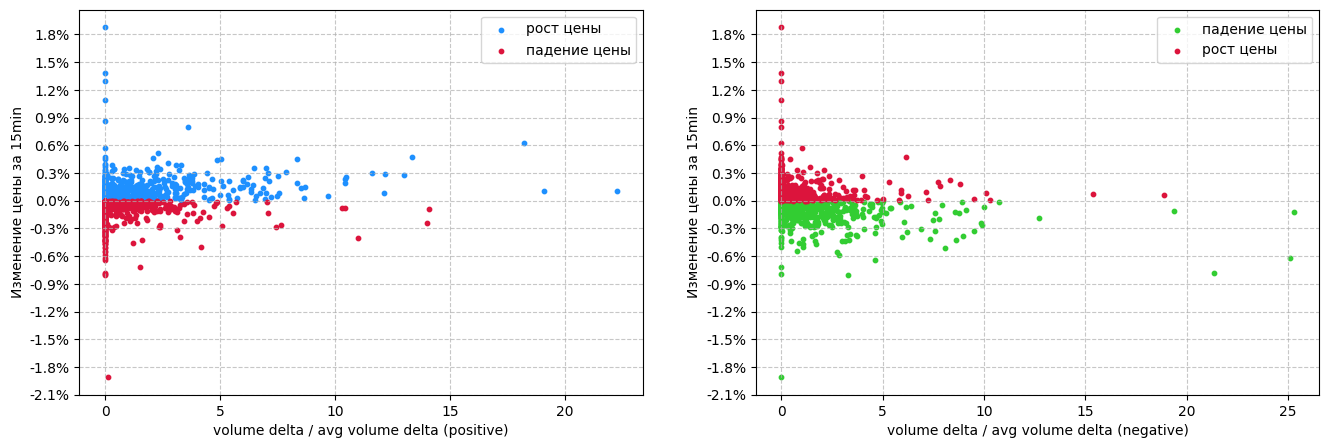

In [ ]:
from matplotlib.ticker import MaxNLocator, MultipleLocator, FuncFormatter


indicators_df_, ratios = vol_del_conditions(indicators_df, 12.222222222222221, 30.55555555555557)

fig, axes = plt.subplots(
    1, 2,
    figsize=(16, 5)
)

#при входе в лонг по сигналу с большой положительной дельтой увеличение цены - хорошо, уменьшение - плохо
pos_good_case = ratios['delta_price'] >= 0
pos_bad_case = ratios['delta_price'] < 0

#для шорта наоборот
neg_good_case = pos_bad_case
neg_bad_case = pos_good_case

axes[0].scatter(ratios[pos_good_case]['ratio_pos'], ratios[pos_good_case]['persent_del_price'], color = 'dodgerblue', s=10, label='рост цены')
axes[0].scatter(ratios[pos_bad_case]['ratio_pos'], ratios[pos_bad_case]['persent_del_price'], color = 'crimson', s=10, label='падение цены')
axes[0].legend(loc='upper right')

axes[1].scatter(ratios[neg_good_case]['ratio_neg'], ratios[neg_good_case]['persent_del_price'], color = 'limegreen', s=10, label='падение цены')
axes[1].scatter(ratios[neg_bad_case]['ratio_neg'], ratios[neg_bad_case]['persent_del_price'], color = 'crimson', s=10, label='рост цены')
axes[1].legend(loc='upper right')

axes[0].set_xlabel('volume delta / avg volume delta (positive)')

axes[1].set_xlabel('volume delta / avg volume delta (negative)')

for ax in axes:
    # ось y
    ax.yaxis.set_major_locator(MaxNLocator(nbins=15))  # 15 делений по Y
    
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1%}'))

    # ось х
    ax.xaxis.set_major_locator(MultipleLocator(5))
    
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylabel(f'Изменение цены за {PERIOD_SMALL}', fontsize=10)

# Статистика 
# --сделать вывод изменений > threshold--
pos_total = len(ratios[~ratios['ratio_pos'].isna()])
neg_total = len(ratios[~ratios['ratio_neg'].isna()])

pos_good_pct = 100 * pos_good_case.sum() / pos_total if pos_total > 0 else 0
neg_good_pct = 100 * neg_good_case.sum() / neg_total if neg_total > 0 else 0

pos_avg_change = ratios[pos_good_case | pos_bad_case]['persent_del_price'].mean() * 100
neg_avg_change = ratios[neg_good_case | neg_bad_case]['persent_del_price'].mean() * 100

print(f"Лонг-сигналы (положительная дельта): рост в {pos_good_pct:.1f}% случаев, "
      f"среднее изменение {pos_avg_change:.4f}%")

print(f"Шорт-сигналы (отрицательная дельта): падение в {neg_good_pct:.1f}% случаев, "
      f"среднее изменение {neg_avg_change:.4f}%")

получаем графики где визуально можем определить коэффицент отношения выше которого "хороших" случаев заметно больше чем "плохих", записываем эти значения в переменную threshold

вход в позиции

In [276]:
def create_opens(indicators_df):

    open_pos_long = (
        indicators_df['vol_open_long']
        #   & indicators_df['VAL_buy']
    )

    open_pos_short = (
        indicators_df['vol_open_short'] 
        # & indicators_df['VAH_sell']
    )

    #открытие и закрытие позиций    
    longs_open  = indicators_df.index[ open_pos_long.fillna(False) ].unique()
    shorts_open = indicators_df.index[ open_pos_short.fillna(False) ].unique()

    return longs_open, shorts_open

расчет TP/SL

In [290]:
#параметры стратегии
# RISK_REWARD_RATIO = 1.8
# RISK_PERCENT = 1 
# N_TICKS_SL = 15
# VOLATILITY_WINDOW = '24h'
# COEFFICENT = 2

def calculate_atr_with_tail(VOLATILITY_WINDOW, df_today, df_prev_day): #найти проблему
    """
    Считает ATR и волатильность, добавляя хвост из предыдущего дня.
    
    VOLATILITY_WINDOW — например, '12h' или '24h'
    df_today — DataFrame с колонками ['recv_time', 'price']
    df_prev_day — DataFrame с предыдущим днём (можно None для первого дня)
    """
    if df_prev_day is not None:
        # Определяем длину окна в часах
        hours = int(pd.Timedelta(VOLATILITY_WINDOW) / pd.Timedelta("1h"))
        tail_start_time = df_today['recv_time'].min() - pd.Timedelta(hours=hours)
        
        # Берём хвост, который попадает в окно
        df_tail = df_prev_day[df_prev_day['recv_time'] >= tail_start_time]
        
        # Склеиваем хвост с сегодняшними данными
        df_today = pd.concat([df_tail, df_today], ignore_index=True)

    # Теперь считаем так же, как раньше
    df_today = df_today.set_index('recv_time')

    df_today['price_diff'] = df_today['price'].diff().abs()
    df_today['volatility'] = df_today['price_diff'].rolling(VOLATILITY_WINDOW).mean().bfill()

    df_today = df_today.reset_index()

    ticks = df_today.set_index('recv_time')['price']
    ticks = ticks[~ticks.index.duplicated(keep='first')]

    vol_series = df_today.set_index('recv_time')['volatility']
    vol_series = vol_series[~vol_series.index.duplicated(keep='first')]

    # origin = pd.to_datetime(df_today['recv_time']).min().floor('15min') # НЕ ПОМОГЛО
    bars = df_today.set_index('recv_time').resample('15min', origin='start_day').agg(
        high=('price', 'max'),
        low=('price', 'min'),
        close=('price', 'last')
    )
    bars['prev_close'] = bars['close'].shift()
    bars['tr'] = bars.apply(
        lambda r: max(
            r.high - r.low,
            abs(r.high - r.prev_close),
            abs(r.low - r.prev_close)
        ), axis=1
    )
    bars['ATR'] = bars['tr'].rolling(window=14).mean().bfill() # ЧТО ЗА WINDOW 14?

    return bars, ticks

In [309]:
#нужно переделать логику потому что сейчас он ищет ближайшую цену по 15 минутам а не рил цену

def get_nearest_tick(ts, ticks):
    pos = ticks.index.get_indexer([ts], method='nearest')[0]
    return pos

#фуекция расчета цены TP/SL и нахождения их временных меток 
def find_exit_point(open_ts, direction, COEFFICENT, RISK_REWARD_RATIO, ticks, bars):
    pos = get_nearest_tick(open_ts, ticks)# ТУТ мб РАСХОЖДЕНИЕ МЕЖДУ НАЙДЕННОЙ ЦЕНОЙ И ПРИСВОЕННЫМ ВРЕМЕНЕМ
    close_index = ticks.iloc[pos]
    atr = bars.loc[close_index, 'ATR'] # тут было bars.loc[OPEN_TS, 'ATR']

    # сюда
    entry_price = ticks.iloc[pos]

    sl_amount = COEFFICENT * atr
    tp_amount = RISK_REWARD_RATIO * COEFFICENT * atr

    future = ticks.iloc[pos+1:] 

    if direction == 'long':
        sl_price = entry_price - sl_amount
        tp_price = entry_price + tp_amount

        ts_sl = future[future <= sl_price].index.min() if not future[future <= sl_price].empty else None
        ts_tp = future[future >= tp_price].index.min() if not future[future >= tp_price].empty else None
    else:
        sl_price = entry_price + sl_amount
        tp_price = entry_price - tp_amount

        ts_tp = future[future <= tp_price].index.min() if not future[future <= tp_price].empty else None
        ts_sl = future[future >= sl_price].index.min() if not future[future >= sl_price].empty else None

    if ts_sl is not None and ts_tp is not None:
        return (min(ts_sl, ts_tp), sl_price)

    return (ts_sl, sl_price) or (ts_tp, sl_price)#возвращает tuple потому что sl_price понадобится позже в расчете размера позиции

соотнесение временных меток с ценами и создания списков трейдов

In [310]:
def make_trades(longs_open, longs_close, shorts_open, shorts_close, ticks):
    trades = []

    #соотносим время/цену открытия и закрытия и добавляем в список trades[]
    for open_ts, close_ts in zip(longs_open, longs_close):
        if close_ts[0] is None:
            continue

        pos_o = get_nearest_tick(open_ts, ticks)
        pos_c = get_nearest_tick(close_ts[0], ticks)

        actual_open_ts  = ticks.index[pos_o]
        actual_close_ts = ticks.index[pos_c]

        entry_price = ticks.iloc[pos_o]
        exit_price  = ticks.iloc[pos_c]

        trades.append({
            'direction':   'long',
            'entry_time':  actual_open_ts,
            'exit_time':   actual_close_ts,
            'entry_price': entry_price,
            'exit_price':  exit_price,
            'profit':      exit_price - entry_price,
            'return':      (exit_price - entry_price) / entry_price,
            'sl_price':    close_ts[1]
        })

    #то же самое для шортов
    for open_ts, close_ts in zip(shorts_open, shorts_close):
        if close_ts[0] is None:
            continue

        pos_o = get_nearest_tick(open_ts, ticks)
        pos_c = get_nearest_tick(close_ts[0], ticks)

        actual_open_ts  = ticks.index[pos_o]
        actual_close_ts = ticks.index[pos_c]

        entry_price = ticks.iloc[pos_o]
        exit_price  = ticks.iloc[pos_c]

        trades.append({
            'direction':   'short',
            'entry_time':  actual_open_ts,
            'exit_time':   actual_close_ts,
            'entry_price': entry_price,
            'exit_price':  exit_price,
            'profit':      entry_price - exit_price,
            'return':      (entry_price - exit_price) / entry_price,
            'sl_price':    close_ts[1]
    })
    
    return trades

расчет доходности стратегии

In [311]:
def fill_order(odf, entry_time, size, direction):
    if odf.empty:
        return None, None

    recv_times = odf['recv_time']

    # Если нужного времени в этом дне нет — пропускаем
    if entry_time < recv_times.iloc[0] or entry_time > recv_times.iloc[-1]:
        return None, None

    # 1. Находим стартовую позицию
    pos = recv_times.searchsorted(entry_time, side='left')

    # Корректируем позицию для ближайшего времени
    if pos == len(odf):
        pos = len(odf) - 1
    elif pos > 0:
        diff_prev = abs(recv_times.iloc[pos-1] - entry_time)
        diff_next = abs(recv_times.iloc[pos] - entry_time)
        if diff_prev < diff_next:
            pos -= 1

    # 2. Определяем сторону сделки
    target_side = 'Sell' if direction == 'long' else 'Buy'

    # 3. Ищем достаточный объём
    curr_size = 0.0
    for i in range(pos, len(odf)):
        row = odf.iloc[i]
        if row['side'] == target_side:
            curr_size += float(row['size'])
            if curr_size >= size:
                return float(row['price']), row['recv_time']

    return None, None

создание price_series

In [312]:
def make_price_series(ticks_by_day):
    price_parts = []
    for day_df in ticks_by_day:
        if not day_df.empty:
            price_parts.append(day_df.set_index('recv_time')['price'])
    return pd.concat(price_parts)

подсчет доходности

In [313]:
def equity_calc(trades):
    price_ser = make_price_series(ticks_by_day)
    times  = [trades[0]['entry_time'] if trades else df['recv_time'].iloc[0]]
    DEPOSIT = 10_000
    RISK_PERCENT = 0.01   # 1%
    FEE          = 0.00075  # комиссия bybit

    equity = [DEPOSIT]

    for tr in trades:
        entry_price = tr['entry_price']
        entry_time = tr['entry_time']
        sl_price    = tr['sl_price'] 
        exit_price  = tr['exit_price']
        exit_time  = tr['exit_time']
        direction   = tr['direction']

        # долларовый риск
        risk_usd = equity[-1] * RISK_PERCENT

        for day_idx, day_df in enumerate(ob_by_day):
            act_entry_price, act_entry_time = fill_order(day_df, entry_time, risk_usd, direction)
            if act_entry_price is not None:
                break

        # поиск выхода начиная с того же дня
        act_exit_price, act_exit_time = None, None
        for day_df in ob_by_day[day_idx:]:
            act_exit_price, act_exit_time = fill_order(day_df, exit_time, risk_usd, direction)
            if act_exit_price is not None:
                break
        
        #расстояние до SL
        stop_distance = abs(entry_price - sl_price)
        if stop_distance == 0:
            # защита от деления на ноль
            position_size = 0
        else:
            position_size = risk_usd / stop_distance

        #PnL, в контрактах умножаем на разницу цен
        if direction == 'long':
            pnl = position_size * (act_exit_price - act_entry_price)
        else:  # short
            pnl = position_size * (act_entry_price - act_exit_price)

        #комиссия на открытие+закрытие
        notional_entry = position_size * act_entry_price
        notional_exit  = position_size * act_exit_price
        commission = (notional_entry + notional_exit) * FEE

        net_pnl = pnl - commission

        # записываем новое equity
        equity.append(equity[-1] + net_pnl)

        # times.append(tr['exit_time'])
        times.append(act_entry_time)

    #расчёт buy&hold
    bh_price = price_ser
    bh_equity = DEPOSIT * (bh_price / bh_price.iloc[0])

    return equity, bh_equity, times



грид серч (очень долгий)

In [314]:
# vol_window = ['12h', '24h']
# coefficent = np.linspace(1.0, 4.0, num=10, endpoint=True)
# RRR = np.linspace(1.0, 4.0, num=10, endpoint=True)
# thresholds_long = np.linspace(10.0, 30.0, num=10, endpoint=True)
# thresholds_short = np.linspace(15.0, 35.0, num=10, endpoint=True)

# strat_returns = {
#         'equity': [],
#         'RRR': [],
#         'coefficent': [],
#         'window': [],
#         'threshold_long': [],
#         'threshold_short': [],
# }

# precomputed_atr = {}
# for window in vol_window:
#     bars, ticks = calculate_atr(window, df)
#     precomputed_atr[window] = (bars, ticks)

# for window in vol_window:
#     for coef in coefficent:
#         for rrr in RRR:
#             for threshold_long in thresholds_long:
#                 for threshold_short in thresholds_short:
                    
#                     indicators_df_, ratios = vol_del_conditions(indicators_df, threshold_long, threshold_short)
#                     longs_open, shorts_open = create_opens(indicators_df_)
#                     bars, ticks = precomputed_atr[window]

#                     longs_close  = [find_exit_point(ts, 'long', coef, rrr, ticks, bars)  for ts in longs_open]
#                     shorts_close = [find_exit_point(ts, 'short', coef, rrr, ticks, bars) for ts in shorts_open]

#                     trades = make_trades(longs_open, longs_close, shorts_open, shorts_close, ticks)

#                     equity, bh_equity, times =  equity_calc(trades)

#                     strat_returns['equity'].append((equity[-1]-equity[0])/100)
#                     strat_returns['RRR'].append(rrr)
#                     strat_returns['coefficent'].append(coef)
#                     strat_returns['window'].append(window)
#                     strat_returns['threshold_long'].append(threshold_long)
#                     strat_returns['threshold_short'].append(threshold_short)

# max_eq    = max(strat_returns['equity'])
# max_index = strat_returns['equity'].index(max_eq)
# print(
#     f"Максимальный доход: {max_eq:.5f}%\n"
#     f"RRR: {strat_returns['RRR'][max_index]}\n"
#     f"window: {strat_returns['window'][max_index]}\n"
#     f"coefficent: {strat_returns['coefficent'][max_index]}"
#     f"сколько бабок в чистом виде: {max_eq*100} "
#     f'threshold_long: {strat_returns['threshold_long'][max_index]}'
#     f'threshold_short: {strat_returns['threshold_short'][max_index]}'
# )

вызов функций с лучшими параметрами

In [316]:
COEFFICENT = 1.6666666666666665
RRR = 2
WINDOW = '12h'

indicators_df_, ratios = vol_del_conditions(indicators_df, 4, 7)
longs_open, shorts_open = create_opens(indicators_df_)

bars_all = []
ticks_all = []

for i, df_day in enumerate(ticks_by_day):
    df_prev = ticks_by_day[i-1] if i > 0 else None
    bars, ticks = calculate_atr_with_tail(WINDOW, df_day, df_prev)
    
    # Обрезаем хвост, оставляем только сегодняшний день
    start_time = df_day['recv_time'].min()
    bars = bars[bars.index >= start_time]
    ticks = ticks[ticks.index >= start_time]
    
    bars_all.append(bars)
    ticks_all.append(ticks)

# Склеиваем результат
bars_all = pd.concat(bars_all)
ticks_all = pd.concat(ticks_all)

print(ticks_all, '\n', bars_all)

# убираем те open_ts, которых нет в bars_all
# longs_open  = [ts for ts in longs_open  if ts in bars_all.index]
# shorts_open = [ts for ts in shorts_open if ts in bars_all.index]

longs_close  = [find_exit_point(ts, 'long', COEFFICENT, RRR, ticks_all, bars_all)  for ts in longs_open]
shorts_close = [find_exit_point(ts, 'short', COEFFICENT, RRR, ticks_all, bars_all) for ts in shorts_open]

for ts in longs_open + shorts_open:
    if ts not in ticks_all.index:
        print("⚠️ Нет ticks для", ts)
    if ts not in bars_all.index:
        print("⚠️ Нет bars для", ts)
trades = make_trades(longs_open, longs_close, shorts_open, shorts_close, ticks_all)

equity, bh_equity, times =  equity_calc(trades)


: 

отрисовка точек входа на цене

KeyError: 'RF'

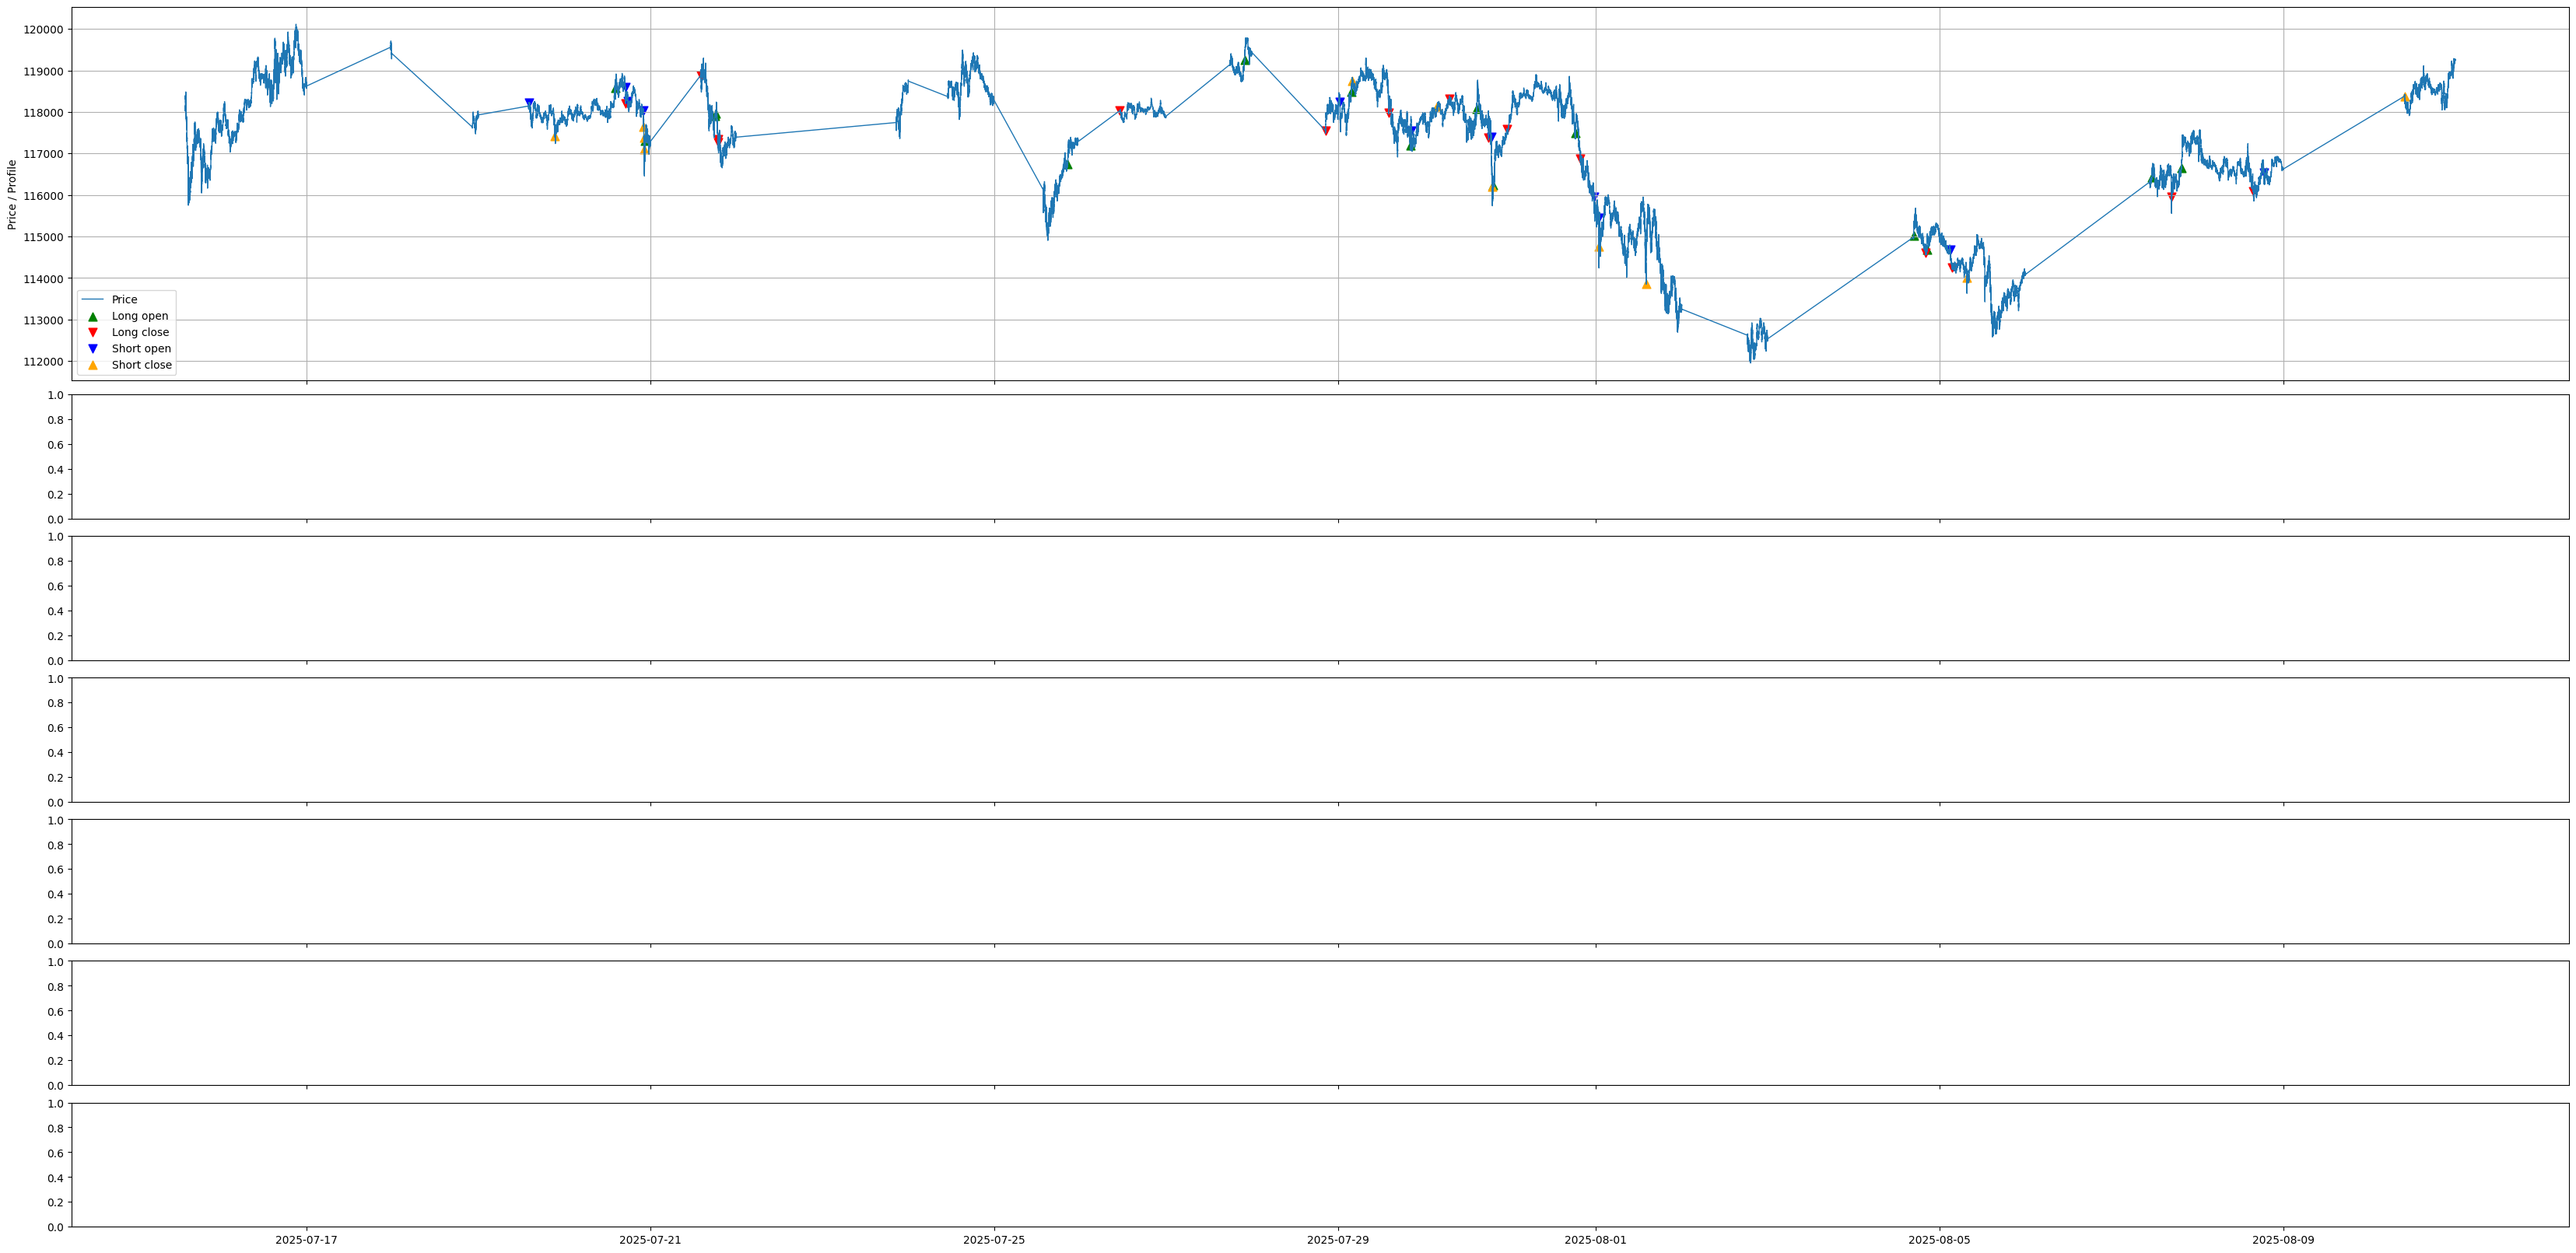

In [ ]:
df = pd.concat(ticks_by_day, ignore_index=True)
df['recv_time']  = pd.to_datetime(df['recv_time'])

fig, axes = plt.subplots(
    7, 1,
    figsize=(33, 16),
    constrained_layout=True,
    sharex=True,
    gridspec_kw={'height_ratios': [3, 1, 1, 1, 1, 1, 1]}
)
ax0 = axes[0]

# цена
ax0.plot(df['recv_time'], df['price'], label='Price', linewidth=1)
# ax0.plot(indicators_df.index, indicators_df['VAH'], label='VAH')
# ax0.plot(indicators_df.index, indicators_df['VAL'], label='VAL')

# 1)разделяем trades на два списка
trades_long  = [t for t in trades if t['direction'] == 'long']
trades_short = [t for t in trades if t['direction'] == 'short']

# извлекаем отдельно entry/exit времена и цены для каждого направления
long_open_times  = [t['entry_time']  for t in trades_long]
long_open_prices = [t['entry_price'] for t in trades_long]
long_close_times  = [t['exit_time']  for t in trades_long]
long_close_prices = [t['exit_price'] for t in trades_long]

short_open_times  = [t['entry_time']   for t in trades_short]
short_open_prices = [t['entry_price']  for t in trades_short]
short_close_times  = [t['exit_time']   for t in trades_short]
short_close_prices = [t['exit_price']  for t in trades_short]

#наносим на график

ax0.scatter(long_open_times,  long_open_prices,  marker='^', color='g', s=60, label='Long open')
ax0.scatter(long_close_times, long_close_prices, marker='v', color='r', s=60, label='Long close')

ax0.scatter(short_open_times,  short_open_prices,  marker='v', color='b',      s=60, label='Short open')
ax0.scatter(short_close_times, short_close_prices, marker='^', color='orange', s=60, label='Short close')

ax0.set_ylabel("Price / Profile")
ax0.legend(loc='lower left')
ax0.grid(True)

indicators = ['RF','VPIN','OFI','Kyle_Lambda','volume_delta', 'cum_delta']
titles = ['Rotation Factor', 'VPIN', 'Order Flow Imbalance', "Kyle's Lambda", 'Volume Delta', 'Cummulutive Delta']

for i, indicator in enumerate(indicators, start=1):
    if indicator == 'volume_delta':
        colors = np.where(indicators_df[indicator] >= 0, 'green', 'red')
        axes[i].bar(indicators_df.index, indicators_df[indicator], color=colors, alpha=0.7, width=0.01)
        axes[i].axhline(0, color='gray', linestyle='-', alpha=0.5)
    else:
        axes[i].plot(indicators_df.index, indicators_df[indicator], label=titles[i-1], linewidth=1.2)
    
    #ключевые уровни для каждого индикатора
    if indicator == 'RF':
        axes[i].axhline(0.5, color='gray', linestyle='--', alpha=0.7)
        axes[i].axhline(2.0, color='gray', linestyle='--', alpha=0.7)
    elif indicator == 'VPIN':
        axes[i].axhline(0.1, color='gray', linestyle='--', alpha=0.7)
        axes[i].axhline(0.3, color='gray', linestyle='--', alpha=0.7)
    elif indicator == 'Kyle_Lambda':
        axes[i].axhline(0.05, color='gray', linestyle='--', alpha=0.7)
        axes[i].axhline(0.2, color='gray', linestyle='--', alpha=0.7)
    elif indicator == 'OFI':
        axes[i].axhline(0, color='gray', linestyle='-', alpha=0.5)
    elif indicator == 'cum_delta':
        axes[i].axhline(0, color='gray', linestyle='-', alpha=0.5)
    
    axes[i].set_ylabel(titles[i-1])
    axes[i].grid(True, alpha=0.3)
    axes[i].legend(loc='best')

for ax in axes:
    #локатор дат каждые 3 часа
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
    
    #формат дата время
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
    
    #дополнительные минорные деления (каждый час)
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
    
    #поворот меток
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.subplots_adjust(bottom=0.15)
# plt.tight_layout()
plt.show()

отрисовка дохода

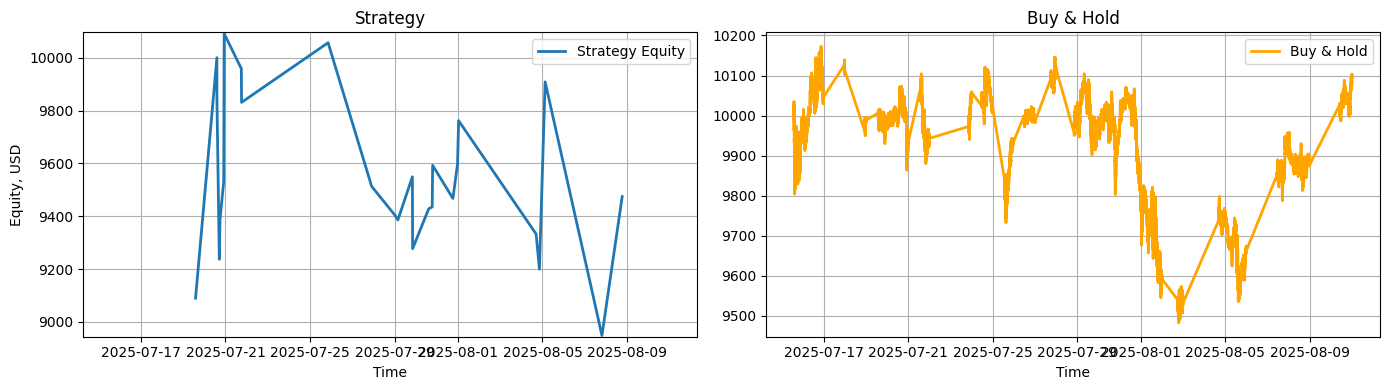

Strategy returns:
-5.25813 %, Balance: 9474.18742
Buy&Hold returns:
1.01916 %, Balance: 10101.91602


/var/folders/9g/ksvcj0yd2b714fy6c81b26v00000gn/T/ipykernel_73857/1979729276.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Buy&Hold returns:\n{(bh_equity[-1]-bh_equity[0])/100:.5f} %, Balance: {bh_equity[-1]:.5f}')


In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14,4),sharex=True, sharey=False)

# Стратегия
pts = sorted(zip(times, equity), key=lambda x: x[0])
times_sorted, equity_sorted = zip(*pts)

ax0.plot(times_sorted, equity_sorted, label='Strategy Equity', linewidth=2)
ax0.set_title("Strategy")
ax0.set_xlabel("Time")
ax0.set_ylabel("Equity, USD")
ax0.legend()
ax0.grid(True)
# Сузим диапазон Y, чтобы мелкие изменения было видно:
y_min = min(equity)*0.9995
y_max = max(equity)*1.0005
ax0.set_ylim(y_min, y_max)

# Buy & Hold
ax1.plot(bh_equity.index, bh_equity.values, 
         label='Buy & Hold', color='orange', linewidth=2)
ax1.set_title("Buy & Hold")
ax1.set_xlabel("Time")
ax1.legend()
ax1.grid(True)


plt.tight_layout()
plt.show()

print(f'Strategy returns:\n{(equity[-1]-equity[0])/100:.5f} %, Balance: {equity[-1]:.5f}')
print(f'Buy&Hold returns:\n{(bh_equity[-1]-bh_equity[0])/100:.5f} %, Balance: {bh_equity[-1]:.5f}')
